# Segmenting and Clustering Neighborhoods in Toronto

- Using Julia to perform web scraping and create DataFrame
- Calling folium and other Python libraries via PyCall

In [37]:
using HTTP, JSON3
using DataFrames, CSV
using Plots, PlotThemes
using Pkg, PyCall, Conda
using StatsBase, Flux

In [38]:
using OpenStreetMapX
using OpenStreetMapXPlot
using ScikitLearn
using Cascadia, Gumbo
using Clustering
using CategoricalArrays

In [39]:
flm = pyimport("folium")
mpl_cm = pyimport("matplotlib.cm")
mpl_colors = pyimport("matplotlib.colors")
cmap = mpl_cm.get_cmap("prism")

## Scraping Toronto Postcode Table

In [40]:
# Set our url for M postal codes in Toronto
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

"https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [41]:
# Grab the page
res = HTTP.get(url);

In [42]:
# Parse into HTML
body = String(res.body)
html = parsehtml(body)
table = eachmatch(sel".wikitable", html.root)[1]
trows = table.children[1].children;

In [43]:
# Extract header
header = trows[1]
colnames = []
for col in header.children
    push!(colnames, chomp(col.children[1].text))
end

In [44]:
# Extract table data
postcodes = []
boroughs = []
neighborhoods = []

for row in trows[2:end]
    push!(postcodes, chomp(row.children[1].children[1].text))
    push!(boroughs, chomp(row.children[2].children[1].text))
    push!(neighborhoods, chomp(row.children[3].children[1].text))
end

In [45]:
# Create DataFrame, filter out unassigned boroughs
df = DataFrame(
    colnames[1] => postcodes, 
    colnames[2] => boroughs, 
    colnames[3] => neighborhoods
)
df = df[df[:District] .≠ "Not assigned", :]
head(df)

,Postal Code,District,Neighbourhood
,Any,Any,Any
1,M3A,North York,Parkwoods
2,M4A,North York,Victoria Village
3,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,M6A,North York,"Lawrence Manor, Lawrence Heights"
5,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
6,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"


In [46]:
# Print dataframe dimensions
size(df)

(103, 3)

## Adding Geocoding data


In [47]:
geo_df = CSV.read("./Geospatial_Coordinates.csv")
head(geo_df)

,Postal Code,Latitude,Longitude
,String,Float64,Float64
1,M1B,43.8067,-79.1944
2,M1C,43.7845,-79.1605
3,M1E,43.7636,-79.1887
4,M1G,43.771,-79.2169
5,M1H,43.7731,-79.2395
6,M1J,43.7447,-79.2395


In [48]:
# Join dataframes
latlong_df = leftjoin(df, geo_df, on="Postal Code")
head(latlong_df)

,Postal Code,District,Neighbourhood,Latitude,Longitude
,Any,Any,Any,Float64?,Float64?
1,M3A,North York,Parkwoods,43.7533,-79.3297
2,M4A,North York,Victoria Village,43.7259,-79.3156
3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6543,-79.3606
4,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7185,-79.4648
5,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623,-79.3895
6,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.6679,-79.5322


In [50]:
# Just Toronto
toronto_df = latlong_df[occursin.(r"Toronto", latlong_df[:District]), :]
unique(toronto_df[:District])
unique(toronto_df[:Neighbourhood]);

## Clustering Neighborhoods

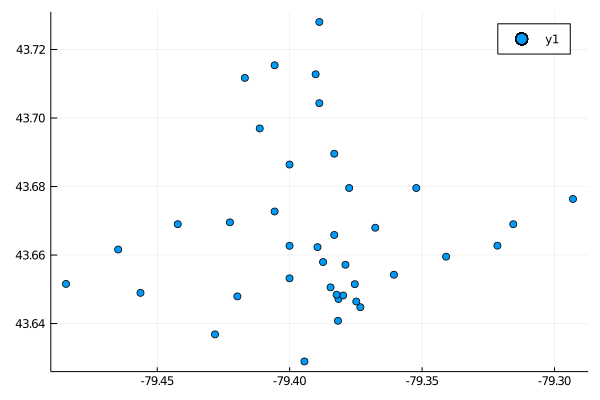

In [51]:
scatter(toronto_df[:Longitude], toronto_df[:Latitude])

In [53]:
# Transform into matrix, permute dimensions
toronto_matrix = convert(Matrix, toronto_df)
toronto_matrix_reshaped = permutedims(convert(Matrix{Float64}, toronto_matrix[:, 4:5]), [2, 1]);

In [54]:
results = kmeans(toronto_matrix_reshaped, 4)

KmeansResult{Array{Float64,2},Float64,Int64}([43.66943648 43.69699297272728 43.653598179999996 43.65200936111111; -79.32465436 -79.39915269090909 -79.45519778 -79.38417313333333], [4, 4, 4, 4, 1, 4, 4, 2, 4, 3  …  2, 4, 2, 4, 2, 4, 4, 4, 4, 1], [0.0005590662767644972, 0.0001342376162938308, 5.3963671234669164e-5, 7.691981227253564e-5, 0.0010479233824298717, 0.00017048266454366967, 4.5620385208167136e-5, 0.0013016312514082529, 2.2238309611566365e-6, 0.00040477744914824143  …  0.0003108060664089862, 0.00025348389681312256, 0.00011275454744463786, 0.000636882567050634, 0.0007713846061960794, 0.00011806668771896511, 0.000526824744156329, 1.640075061004609e-5, 0.00019286406677565537, 5.437807340058498e-5], [5, 11, 5, 18], [5, 11, 5, 18], 0.015241255641740281, 4, true)

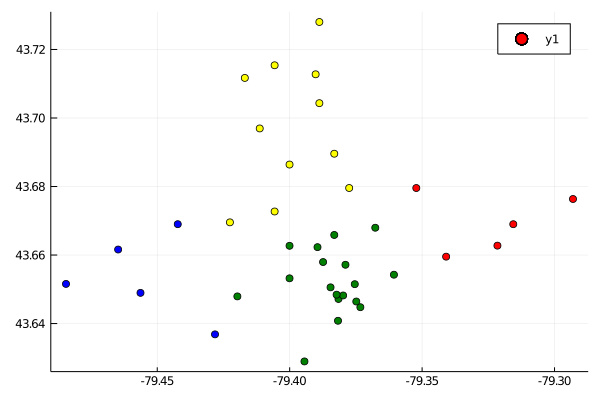

In [55]:
# Clusters based on number of Boroughs

colors = ["red" "yellow" "blue" "green"]
scatter(toronto_df[:Longitude], toronto_df[:Latitude], color=colors[results.assignments])

In [56]:
toronto_map = flm.Map(
    location=(43.6529, -79.3849),
    tiles="OpenStreetMap"
)

# add markers to the map
colors = ["red" "yellow" "blue" "green"]
for (lat, lon, poi, cluster) in zip(
        toronto_df[:Latitude], 
        toronto_df[:Longitude], 
        toronto_df[:Neighbourhood], 
        results.assignments
        )
    label = flm.Popup("Cluster $(cluster): $poi", parse_html=true)
    flm.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=true,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(toronto_map)
end
toronto_map

PyObject <folium.folium.Map object at 0x7f8e52f4bdc0>

## Using Foursquare Data

In [57]:
# Parameters

CLIENT_ID = "CAFNA0SXY1KWV0NGK0KBLTDBRG1CGN5AP5WGY4VJYZA4R0FZ" # your Foursquare ID
CLIENT_SECRET = "TPGMEC1PP140BNTKW11RI43E0I15545FBOYXG4OUORJ4JDA3" # your Foursquare Secret
VERSION = "20200826"  #Foursquare API version
LIMIT = 100
RADIUS = 500

500

In [58]:
function get_nearby_venues(names, latitudes, longitudes, radius=RADIUS)
    venues_list = []
    
    for (name, lat, lng) in zip(names, latitudes, longitudes)           
        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?&client_id=$(CLIENT_ID)&client_secret=$(CLIENT_SECRET)&v=$(VERSION)&ll=$(lat),$(lng)&radius=$(radius)&limit=$(LIMIT)"
            
        # make the GET request
        results = JSON3.read(HTTP.get(url).body)[:response][:groups][1][:items]
        
        # return only relevant information for each nearby venue
        push!(venues_list, [(
            name, 
            lat, 
            lng, 
            v[:venue][:name], 
            v[:venue][:location][:lat], 
            v[:venue][:location][:lng],  
            v[:venue][:categories][1][:name]) 
                for v in results]
        )
    end
    
    nearby_venues = DataFrame([item for venue_list in venues_list for item in venue_list])
    rename!(nearby_venues, [:Neighbourhood, :Latitude, :Longitude, :Venue, :VenueLat, :VenueLng, :Category])
    return(nearby_venues)
end

get_nearby_venues (generic function with 2 methods)

In [59]:
toronto_venues = get_nearby_venues(toronto_df[:Neighbourhood], toronto_df[:Latitude], toronto_df[:Longitude]);

In [60]:
Base.displaysize() = (7, 133)
println(size(toronto_venues))
head(toronto_venues)

(1635, 7)


,Neighbourhood,Latitude,Longitude,Venue,VenueLat,VenueLng,Category
,SubStri…,Float64,Float64,String,Float64,Float64,String
1,"Regent Park, Harbourfront",43.6543,-79.3606,Roselle Desserts,43.6534,-79.362,Bakery
2,"Regent Park, Harbourfront",43.6543,-79.3606,Tandem Coffee,43.6536,-79.3618,Coffee Shop
3,"Regent Park, Harbourfront",43.6543,-79.3606,Cooper Koo Family YMCA,43.6532,-79.358,Distribution Center
4,"Regent Park, Harbourfront",43.6543,-79.3606,Body Blitz Spa East,43.6547,-79.3599,Spa
5,"Regent Park, Harbourfront",43.6543,-79.3606,Impact Kitchen,43.6564,-79.357,Restaurant
6,"Regent Park, Harbourfront",43.6543,-79.3606,Corktown Common,43.6556,-79.3562,Park


## Create One-Hot Encoded matrix

In [62]:
onehot_matrix = Flux.onehotbatch(toronto_venues[!, :Category], unique(toronto_venues[!, :Category])) |> permutedims
colnames = unique(toronto_venues[:Category])
onehot_df = DataFrame(onehot_matrix)
rename!(onehot_df, colnames)
toronto_onehot = hcat(toronto_venues, onehot_df)
head(toronto_onehot)

,Neighbourhood,Latitude,Longitude,Venue,VenueLat,VenueLng,Category,Bakery,Coffee Shop
,SubStri…,Float64,Float64,String,Float64,Float64,String,Bool,Bool
1,"Regent Park, Harbourfront",43.6543,-79.3606,Roselle Desserts,43.6534,-79.362,Bakery,1,0
2,"Regent Park, Harbourfront",43.6543,-79.3606,Tandem Coffee,43.6536,-79.3618,Coffee Shop,0,1
3,"Regent Park, Harbourfront",43.6543,-79.3606,Cooper Koo Family YMCA,43.6532,-79.358,Distribution Center,0,0
4,"Regent Park, Harbourfront",43.6543,-79.3606,Body Blitz Spa East,43.6547,-79.3599,Spa,0,0
5,"Regent Park, Harbourfront",43.6543,-79.3606,Impact Kitchen,43.6564,-79.357,Restaurant,0,0
6,"Regent Park, Harbourfront",43.6543,-79.3606,Corktown Common,43.6556,-79.3562,Park,0,0


## Group by Neighborhood

In [63]:
grouped_venues = groupby(toronto_onehot, :Neighbourhood)

GroupedDataFrame with 39 groups based on key: Neighbourhood
First Group (45 rows): Neighbourhood = "Regent Park, Harbourfront"
⋮
Last Group (18 rows): Neighbourhood = "Business reply mail Processing Centre, South Central Letter Processing Plant Toronto"

## Compute proportions of Categories by Neighborhood

In [64]:
# Proportions of each
proportions_venues = combine(map(x->x[:, 8:end], grouped_venues), valuecols(map(x -> x[:, 8:end], grouped_venues)) .=> mean)
proportions_matrix = permutedims(convert(Matrix, proportions_venues[:, 2:end]));

## K-Means Clustering on Proportions of Venue Categories

In [65]:
kclusters = 10
results = kmeans(proportions_matrix, kclusters)

KmeansResult{Array{Float64,2},Float64,Int64}([0.028597151640629898 0.125 … 0.0 0.014907080710705223; 0.04544827153522806 0.0 … 0.058823529411764705 0.08693975697176853; … ; 0.0 0.0 … 0.0 0.0024154589371980675; 0.0 0.0 … 0.0 0.0024154589371980675], [10, 4, 10, 10, 8, 10, 4, 9, 10, 2  …  6, 1, 10, 7, 5, 10, 10, 10, 10, 10], [0.026191225059238488, 0.008021308541779987, 0.013313659185701918, 0.012324598725656048, 0.0, 0.01320217998202132, 0.008021308541780028, 5.551115123125783e-17, 0.008969445592161514, 0.0  …  0.0, 0.022654987158303837, 0.050523529322251154, 0.0, 0.0625, 0.0076941677500150865, 0.016331887054504883, 0.011774085069616393, 0.01578869618816471, 0.05439752818044319], [6, 1, 1, 2, 2, 1, 1, 1, 1, 23], [6, 1, 1, 2, 2, 1, 1, 1, 1, 23], 1.2345327631978595, 3, true)

In [66]:
toronto_map = flm.Map(
    location=(43.6529, -79.3849),
    tiles="OpenStreetMap"
)

colors = [:red :blue :green :yellow :purple :orange :chartreuse :black :magenta :cyan]

# add markers to the map
for (lat, lon, poi, cluster) in zip(
        toronto_df[:Latitude], 
        toronto_df[:Longitude], 
        toronto_df[:Neighbourhood], 
        results.assignments
        )
    label = flm.Popup("Cluster $(cluster): $poi", parse_html=true)
    flm.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=true,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(toronto_map)
end
toronto_map

PyObject <folium.folium.Map object at 0x7f8dd40704f0>